# Ciphertext Decryption Using MCMC

In [1]:
import random
import numpy as np
import re 
import copy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def encrypt(plaintext,plaintext_alphabet,cipher_alphabet,blacklist={}):
    """
    docs here
    """
    assert set(list(plaintext)).difference(blacklist).issubset(set(list(plaintext_alphabet))),"Plaintext must only contain characters in Plaintext alphabet"
    assert len(plaintext_alphabet) == len(cipher_alphabet), "Cipher alphabet must have same number of characters as Plaintext alphabet"

    enc_key = dict(zip(list(plaintext_alphabet),list(cipher_alphabet)))
    acc = []
    for s in plaintext:
        if s in blacklist:
            acc += s
        else:
            acc += [enc_key[s]]
    ciphertext = "".join(acc)

    return {'cipher_alphabet' : cipher_alphabet,
            'plaintext_alphabet' : plaintext_alphabet,
            'ciphertext' : ciphertext}

def decrypt(ciphertext,plaintext_alphabet,cipher_alphabet,blacklist={}):
    """
    docs here
    """
    dec_key = dict(zip(list(cipher_alphabet),list(plaintext_alphabet)))
    acc = []
    for s in ciphertext:
        
        if s in blacklist:
            acc += [s]
        else:
            acc += [dec_key[s]]
    plaintext = "".join(acc)
    return {'cipher_alphabet' : cipher_alphabet,
            'plaintext_alphabet' : plaintext_alphabet,
            'plaintext' : plaintext}

In [3]:
def process_text(filename,regex_ignore='[^A-Z .]',regularize=True):
    char_bigram_counts = Counter()
    char_unigram_counts = Counter()

    with open(filename,encoding='utf-8') as f:
        cnt = 0
        for line in f:
            cnt += 1
            if cnt % 5000 == 0: print("{0} lines read.".format(cnt))
            if regex_ignore != None:
                pattern = re.compile(regex_ignore)
                s = pattern.sub('',line.upper())
            else:
                s = line.upper()

            line_length = len(s)

            if line_length > 0:
                for i in range(line_length-1):
                    char_bigram_counts[(s[i],s[i+1])] +=1
                    char_unigram_counts[s[i]] += 1

                # Add last character in line	
                char_unigram_counts[s[line_length-1]] += 1 
                
    # Map each unique character from text to an index and vice-versa
    i_c_map = dict(enumerate([q[0] for q in sorted(list(char_unigram_counts.items()),key=lambda x: x[0])]))
    c_i_map = {v: k for k, v in i_c_map.items()}

    # Create first-order transition matrix
    n = len(c_i_map)
    M = np.zeros((n,n))
    if regularize:
        M += 1
        
    for k in char_bigram_counts.keys():
        M[c_i_map[k[0]]][c_i_map[k[1]]] = char_bigram_counts[k]

    # Replace any zero rows (i.e. characters that appear exactly once at the end of a corpus) with a uniform distribution
    zero_rows = np.where(M.sum(axis=1) == 0.)
    M[zero_rows,:] = 1
    row_sums = M.sum(axis=1)
    P = M / row_sums[:,np.newaxis]

    print('{0} uniform row(s) inputed for characters {1}'.format(zero_rows[0].size, 
                                                                [i_c_map[z] for z in zero_rows[0]]))

    return {'char_bigram_counts': char_bigram_counts,
            'char_unigram_counts': char_unigram_counts,
            'bigram_freq_matrix': M,
            'transition_matrix': P,
            'character_index_map': c_i_map,
            'index_character_map': i_c_map}

In [4]:
def plausibility(f,char_index_map,cipher,transition_mtx,blacklist={},print_output=False):
    n = len(cipher)
    probs = np.zeros(n-1)
    q = len(transition_mtx)
    k = []
    v = []
    
    for i,j in f.items():
        k += [i]
        v += [j]
        
    dec = decrypt(cipher,"".join(v),"".join(k),blacklist)['plaintext']
    for i in range(n-1):
        
        # If bigram contains a character not part of the encryption, assign it a uniform transition prob
        if dec[i] in blacklist or dec[i+1] in blacklist:    
            probs[i] = 1/q
        else:
            probs[i] = transition_mtx[c_i_map[dec[i]]][c_i_map[dec[i+1]]]
            
        # Ensures numerical stability
        probs_sorted = np.sort(probs,kind='quicksort')

    return {"score":np.sum(np.log(np.array(probs))),"attempt":dec} 

In [5]:
def solve_mcmc(ciphertext,usual_alphabet,code_space,trans_mtx,char_index_mapping,iters=2500,skip_chars={}):

    # Initialize with a random mapping
    f = dict(zip(list(code_space),list(usual_alphabet)))
    
    scores = [0.0]*iters
    mappings = []
    accepted = 0
    for i in range(0,iters):

        mappings += [f]

        # Create proposal from f by random transposition of 2 letters
        r1, r2 = np.random.choice(list(code_space),2,replace=True)
        f_proposal = f.copy()
        f_proposal[r1] = f[r2]
        f_proposal[r2] = f[r1]

        # Decrypt using the current and proposed mapping
        current = plausibility(f,char_index_mapping,ciphertext,trans_mtx,blacklist=skip_chars)
        f_prob = current['score']
        
        # Print out progress
        if i % 500 == 0: 
            print("iter:", i,current['attempt'][:100])

        f_proposal_prob = plausibility(f_proposal,char_index_mapping,ciphertext,trans_mtx,blacklist=skip_chars)['score']

        # Decide to accept new proposal
        u = random.uniform(0,1)
        if f_proposal_prob > f_prob:
            f = f_proposal.copy()
            scores[i] = f_proposal_prob
            accepted += 1
        elif u < np.exp(f_proposal_prob - f_prob):
            f = f_proposal.copy()
            scores[i] = f_proposal_prob
            accepted += 1
        scores[i] = f_prob

    print("total acceptances: ", accepted)

    # Save best mapping 
    best_f = mappings[np.argmax(scores)]
    best_score = max(scores)
    plains = []
    ciphers = []

    for k in sorted(best_f.keys()):
        ciphers += [k]
        plains += [best_f[k]]
    
    best_key = ("".join(plains),"".join(ciphers))
    best_attempt = decrypt(ciphertext,best_key[0],best_key[1],blacklist=skip_chars)['plaintext']
    
    print("score:",best_score)
    return {'num_iters':iters,
            'plaintext':best_attempt,
            'best_score':best_score,
            'best_key':best_f,
            'scores':scores,
            'total_acceptances': accepted
            }

In [6]:
# Accuracy score
def similarity(s1,s2):
    assert len(s1) == len(s2), "Both strings must be same length"
    n = len(s1)
    num_matches = sum([1 if a == b else 0 for a,b in zip(s1,s2)])
    return num_matches/n    

In [7]:

test_pattern = '[^A-Z ]'
pattern = re.compile(test_pattern)
message = "ENTER HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE OR TO TAKE ARMS AGAINST A SEA OF TROUBLES AND BY OPPOSING END"
message_cleaned = pattern.sub('',message.upper())

# Generate random code space
en_alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ "
tmp = list(en_alphabet)
random.shuffle(tmp)
cipher_alphabet = "".join(tmp)

# Display the true key
message_enc = encrypt(message_cleaned,en_alphabet,cipher_alphabet,
#                      blacklist={' ',}
                    )
ciphertext = message_enc['ciphertext']
print(message_enc)
print(decrypt(message_enc['ciphertext'],en_alphabet, cipher_alphabet,
#               blacklist={' ',}
             ))
print((en_alphabet,cipher_alphabet))

# Compute english bigram frequencies from a reference text
results = process_text('war-and-peace.txt',regex_ignore=test_pattern)
P = results['transition_matrix']
F = results['bigram_freq_matrix']
m = P.shape[0]
i_c_map = results['index_character_map']
c_i_map = results['character_index_map']

{'cipher_alphabet': 'U EOYAHPLNGFMISDQVJZRWTXCBK', 'plaintext_alphabet': 'ABCDEFGHIJKLMNOPQRSTUVWXYZ ', 'ciphertext': 'YIZYVKPUMFYZKZSK YKSVKISZKZSK YKZPUZKLJKZPYKQRYJZLSIKTPYZPYVKZLJKIS FYVKLIKZPYKMLIOKZSKJRAAYVKZPYKJFLIHJKUIOKUVVSTJKSAKSRZVUHYSRJKASVZRIYKSVKZSKZUGYKUVMJKUHULIJZKUKJYUKSAKZVSR FYJKUIOK CKSDDSJLIHKYIO'}
{'cipher_alphabet': 'U EOYAHPLNGFMISDQVJZRWTXCBK', 'plaintext': 'ENTER HAMLET TO BE OR NOT TO BE THAT IS THE QUESTION WHETHER TIS NOBLER IN THE MIND TO SUFFER THE SLINGS AND ARROWS OF OUTRAGEOUS FORTUNE OR TO TAKE ARMS AGAINST A SEA OF TROUBLES AND BY OPPOSING END', 'plaintext_alphabet': 'ABCDEFGHIJKLMNOPQRSTUVWXYZ '}
('ABCDEFGHIJKLMNOPQRSTUVWXYZ ', 'U EOYAHPLNGFMISDQVJZRWTXCBK')
5000 lines read.
10000 lines read.
15000 lines read.
20000 lines read.
25000 lines read.
30000 lines read.
35000 lines read.
40000 lines read.
45000 lines read.
50000 lines read.
55000 lines read.
60000 lines read.
65000 lines read.
0 uniform row(s) inputed for characters []


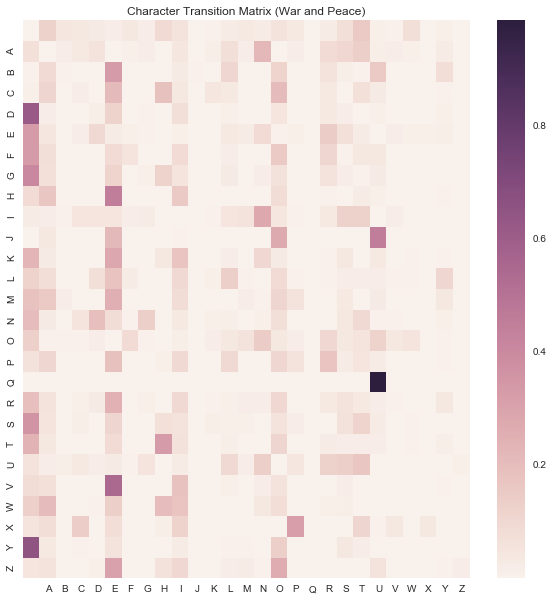

In [8]:
# Plot example of  transition matrix
names = []
for k in sorted(list(i_c_map.keys())):
    names += [i_c_map[k]]
    
plt.figure(figsize=(10,10))
sns.heatmap(P,xticklabels=names,yticklabels=names)
plt.title("Character Transition Matrix (War and Peace)")

In [15]:
init = list(en_alphabet).copy()
random.shuffle(init)
print("ciphertext:")
print(ciphertext)

print()
soln = solve_mcmc(ciphertext,en_alphabet,init,P,c_i_map,iters=5000)
print()

print("attempted decryption:")
print(soln['plaintext'])

# Compare against original message
print()
print("original message:")
print(message_cleaned)
ground_truth_score = plausibility(dict(zip(cipher_alphabet,en_alphabet)),c_i_map,ciphertext,P)

print()
print('score of true key:', ground_truth_score['score'])
print('similarity score:', similarity(message_cleaned, soln['plaintext']))

ciphertext:
YIZYVKPUMFYZKZSK YKSVKISZKZSK YKZPUZKLJKZPYKQRYJZLSIKTPYZPYVKZLJKIS FYVKLIKZPYKMLIOKZSKJRAAYVKZPYKJFLIHJKUIOKUVVSTJKSAKSRZVUHYSRJKASVZRIYKSVKZSKZUGYKUVMJKUHULIJZKUKJYUKSAKZVSR FYJKUIOK CKSDDSJLIHKYIO

iter: 0  QE ISDYAK ESEOSH SOISQOESEOSH SEDYESZRSED SXT REZOQSBD ED ISEZRSQOHK ISZQSED SAZQGSEOSRTFF ISED SRK
iter: 500 EISET HAPUES SO ME OT IOS SO ME SHAS LN SHE RKENSLOI WHESHET SLN IOMUET LI SHE PLID SO NKFFET SHE NU
iter: 1000 EISET HABYES SO ME OT IOS SO ME SHAS LD SHE QUEDSLOI WHESHET SLD IOMYET LI SHE BLIG SO DURRET SHE DY
iter: 1500 EITER HABYET TO ME OR IOT TO ME THAT LD THE FUEDTLOI WHETHER TLD IOMYER LI THE BLIG TO DUSSER THE DY
iter: 2000 ELTER HAPBET TO ME OR LOT TO ME THAT IS THE JUESTIOL WHETHER TIS LOMBER IL THE PILD TO SUGGER THE SB
iter: 2500 ENTER HAKBET TO ME OR NOT TO ME THAT IS THE CUESTION WHETHER TIS NOMBER IN THE KINY TO SULLER THE SB
iter: 3000 ENTER HAYBET TO ME OR NOT TO ME THAT IS THE CUESTION WHETHER TIS NOMBER IN THE YING TO SULLER THE SB
iter: 3

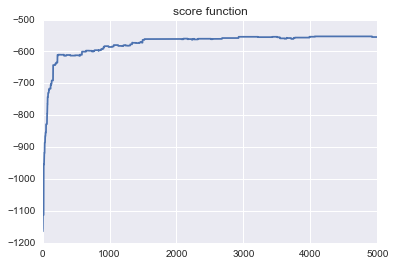

In [14]:
plt.plot(soln['scores'])
plt.title('score function')
plt.show()  

In [346]:
# Try a longer message (some boring prose) and different alphabet
message2 = """For seamless hose the tube is made in a tubing machine and slipped upon the hose pole by reversing the process that is used in removing hose by air compression. In other words, a knot is tied in one end of the fifty foot tube and the other end is placed against the hose pole and being carefully inflated with air it is slipped on without the least trouble. For various kinds of hose the processes vary, and there are machines for winding with wire and intricate processes for the heavy grades of suction hose, etc."""
message_cleaned2 = pattern.sub('',message2.upper())
cipher_alphabet2 = ",./;[]-=!@#$%^&*()<>?:{}|~A"

# Display the true key
message_enc2 = encrypt(message_cleaned2,en_alphabet,cipher_alphabet2,
                    )
ciphertext2 = message_enc2['ciphertext']

In [347]:
init2 = list(cipher_alphabet2).copy()
random.shuffle(init2)
print("ciphertext:")
print(ciphertext2)

print()
soln2 = solve_mcmc(ciphertext2,en_alphabet,init2,P,c_i_map,iters=5000)
print()

print("attempted decryption:")
print(soln2['plaintext'])

# Compare against original message
print()
print("original message:")
print(message_cleaned2)
ground_truth_score2 = plausibility(dict(zip(cipher_alphabet2,en_alphabet)),c_i_map,ciphertext2,P)

print()
print('score of true key:', ground_truth_score2['score'])
print('similarity score:', similarity(message_cleaned2, soln2['plaintext']))

ciphertext:
]&)A<[,%$[<<A=&<[A>=[A>?.[A!<A%,;[A!^A,A>?.!^-A%,/=!^[A,^;A<$!**[;A?*&^A>=[A=&<[A*&$[A.|A)[:[)<!^-A>=[A*)&/[<<A>=,>A!<A?<[;A!^A)[%&:!^-A=&<[A.|A,!)A/&%*)[<<!&^A!^A&>=[)A{&);<A,A#^&>A!<A>![;A!^A&^[A[^;A&]A>=[A]!]>|A]&&>A>?.[A,^;A>=[A&>=[)A[^;A!<A*$,/[;A,-,!^<>A>=[A=&<[A*&$[A,^;A.[!^-A/,)[]?$$|A!^]$,>[;A{!>=A,!)A!>A!<A<$!**[;A&^A{!>=&?>A>=[A$[,<>A>)&?.$[A]&)A:,)!&?<A#!^;<A&]A=&<[A>=[A*)&/[<<[<A:,)|A,^;A>=[)[A,)[A%,/=!^[<A]&)A{!^;!^-A{!>=A{!)[A,^;A!^>)!/,>[A*)&/[<<[<A]&)A>=[A=[,:|A-),;[<A&]A<?/>!&^A=&<[A[>/

iter: 0 QKPUHFIJVFHHUTKHFUGTFUGMAFUWHUJIXFUWNUIUGMAWNEUJIZTWNFUINXUHVWSSFXUMSKNUGTFUTKHFUSKVFUABUPFCFPHWNEUG
iter: 500 TOR SEIWLESS HOSE PHE PMBE AS WIDE AN I PMBANG WIFHANE IND SLAUUED MUON PHE HOSE UOLE BY REZERSANG P
iter: 1000 PAR SEOMLESS HASE THE TUZE IS MODE IN O TUZING MOCHINE OND SLIFFED UFAN THE HASE FALE ZY REBERSING T
iter: 1500 FOR SEAMLESS HOSE THE TUZE IS MADE IN A TUZING MACHINE AND SLIPPED UPON THE HOSE POLE ZY REBERSING T
iter: 2000 FOR SEAMLESS HOSE THE 

In [348]:
# TODO: fix process_text to create uniform rows and debug cryptogram case (fixed word spacing)
# TODO: improve clarity of blacklist system
# TODO: add doc strings for functions

#   """
#     
#     Reads in text from a file and returns a dict containing 3 objects. 

#     The Counter "char_bigram_counts" stores the number of character pairs.
#     The Counter "char_unigram_counts" gives the total count of each character in the text. 
#     The numpy array "transition_mtx" gives the first-order transition probabilities between two characters (i,j) where i and j are indices.
#     The "character_index_map" and "index_character_map" Dict objects specify a bijection between characters and indices of the matrix. 

#     regex_ignore used to pick what characters to include when building the matrix. For example, can only keep alphnumeric characters
#     if regex_ignore='[\W_]+'
#     """

# more test cases (cryptograms)
# # ciphertext = """CKYL VQQ KSB ZQYZOC, ZIK YDD KSB KBQBLSYAB, LHBRBAK KSB WYM DHYG XVHOEAM FEKS V UIEZT XYAB, CEQBAZB KSB LEVAYC VAW FEKS GIDDQBW WHIG XHEAM YIK KSB ZYDDEA, QBK KSB GYIHABHC ZYGB. """
# ciphertext = """CKYL VQQ KSB ZQYZOC ZIK YDD KSB KBQBLSYAB LHBRBAK KSB WYM DHYG XVHOEAM FEKS V UIEZT XYAB CEQBAZB KSB LEVAYC VAW FEKS GIDDQBW WHIG XHEAM YIK KSB ZYDDEA QBK KSB GYIHABHC ZYGB"""